In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from data_utils import load_dataset

## Question 2: GLM using SVD 

In [2]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')

In [3]:
def apply_basis_functions(x):
    omega = 2*math.pi/0.0564
    phi = [None]*5
    phi[0] = 1 
    phi[1] = x**2
    phi[2] = np.sqrt(2)*x 
    phi[3] = x*(math.cos(omega*x)) 
    phi[4] = x*(math.sin(omega*x)) 
    return np.array(phi)

In [4]:
def rmse(pred,true):
    return np.sqrt(np.mean((pred-true)**2))

In [5]:
def GLM_SVD(x_training, y_training, x_testing, y_testing, l_param):
    # Initialize phi matrix 
    Phi = np.empty((x_training.size,5)) # Length of x_train and width based on number of basis functions 
    Phi_valid = np.empty((x_testing.size,5))
    
    # Initialize lambda values 
    lamb_vals = list(range(0,51))
    
    # Construct phi matrix 
    for i in range(x_training.size):
        Phi[i] = apply_basis_functions(x_training[i])
    
    # Construct phi matrix 
    for i in range(x_testing.size):
        Phi_valid[i] = apply_basis_functions(x_testing[i])
            
    # Compute SVD with Phi 
    u, s, vh = np.linalg.svd(Phi)
    
    dummy = np.zeros( ((x_training.size) - (s.size), (s.size)) )
    sigma = np.vstack([np.diag(s), dummy])

    if l_param == -1: # Need to choose lambda 
        # Compute weights and predictions for each lambda to find parameter with minimum rmse value 
        min_rmse = np.inf
        for lamb_val in lamb_vals:
            intermediate = np.linalg.inv(np.dot(sigma.T, sigma) + lamb_val*np.identity((np.dot(sigma.T, sigma).shape[0])))
            w = np.dot(vh.T, np.dot(intermediate, np.dot(sigma.T, np.dot(u.T, y_training))))
            preds = np.dot(Phi_valid, w)
            rmse_val = rmse(y_testing, preds)
            if rmse_val < min_rmse:
                min_rmse = rmse_val
                best_lambda = lamb_val
        return best_lambda
    
    else:
        intermediate = np.linalg.inv(np.dot(sigma.T, sigma) + l_param*np.identity((np.dot(sigma.T, sigma).shape[0])))
        w = np.dot(vh.T, np.dot(intermediate, np.dot(sigma.T, np.dot(u.T, y_training))))
        preds = np.dot(Phi_valid, w)
        rmse_val = rmse(preds,y_testing)

        return [rmse_val,preds]

In [6]:
l_param = GLM_SVD(x_train, y_train, x_valid, y_valid, -1)
print('Optimal choice for regularization parameter: ', l_param)

Optimal choice for regularization parameter:  14


In [171]:
x_total = np.vstack([x_train, x_valid])
y_total = np.vstack([y_train, y_valid])

test_rmse, Q2_preds = GLM_SVD(x_total, y_total, x_test, y_test, l_param)
print('Test RMSE: ', test_rmse)

Test RMSE:  0.10671723698709626


In [0]:
def plot_predsQ2(preds,x_test, y_test):
    plt.figure(1)
    plt.plot(x_test, y_test, label='Actual')
    plt.plot(x_test, preds, label='Predicted')
    plt.title('GLM Predictions for Mauna_loa dataset at lambda=' + str(l_param))
    plt.xlabel('x_test')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('mauna_loa_Q2.jpg')

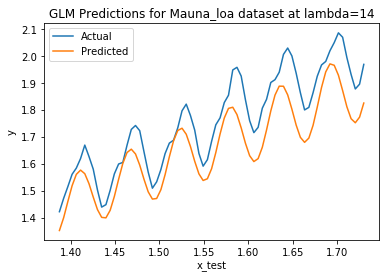

In [173]:
plot_predsQ2(Q2_preds, x_test, y_test)

## Question 3: Kernelized GLM from a Dual Perspective 

Considering the same basis functions used in Q2, construct a kernelized GLM from the
dual perspective. Select a positive regularization parameter, and construct the model
using the Cholesky factorization. Comment on the computational cost and memory
requirements of the dual approach versus the primal approach. Also, visualize your
designed kernel by plotting k(0, z), and by plotting k(1, z + 1) where z ∈ [−0.1, 0.1].
Is your kernel translation-invariant (stationary)? Make your argument based on your
plots of the kernel.

In [0]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
x_total = np.vstack([x_train, x_valid])
y_total = np.vstack([y_train, y_valid])

In [0]:
def kernelize(x1,x2):
    # Polynomial kernel based on polynomial basis functions 
    return (1+x1*x2)**2 + x1*x2*math.cos(2*math.pi/0.0564*(x1-x2))

In [0]:
def GLM_kernelized(x_total, y_total, x_test, y_test, l_param):
    # Under the dual representation, we use the Gram matrix, K, to represent kernelizing

    K = np.empty((x_total.size, x_total.size))

    for i in range(len(x_total)):
        for j in range(len(x_total)):
            x1 = x_total[i]
            x2 = x_total[j]
            
            K[i,j] = kernelize(x1,x2)
            
    # Compute Cholesky factorization with K + lambda*identity as per lecture slides  
    R = np.linalg.cholesky(K+l_param*np.identity(len(K)))
    
    R_inv = np.linalg.inv(R)
    
    # Compute alpha, the dual variables 
    alpha = np.dot(np.dot(R_inv.T, R_inv), y_total)
    
    # Under dual representation, we can compute the predictions based on the kernel instead of the feature vector 
    # of basis functions. Thus, the predictions for each x_test entry can be computed as such:
    
    preds = np.empty(np.shape(y_test))

    for i in range(len(x_test)):
        k_i = np.empty(np.shape(alpha))
        for j in range(len(x_total)):
            k_i[j] = kernelize(x_test[i],x_total[j])
        preds[i] = np.dot(k_i.T,alpha)
    
    rmse_value = rmse(preds, y_test)

    plt.figure(2)
    plt.plot(x_test, y_test, label='Actual')
    plt.plot(x_test, preds, label='Predicted')
    plt.title('Kernelized GLM Predictions for Mauna_loa dataset at lambda=' + str(l_param))
    plt.xlabel('x_test')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('mauna_loa_Q3.jpg')

    return rmse_value

0.10671723698708326

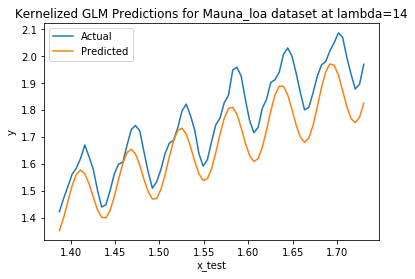

In [177]:
GLM_kernelized(x_total, y_total, x_test, y_test, 14)

In [0]:
def kernel_viz():
    for i in range(2):
        y_vals = list([])
        z = np.linspace(-0.1+i,0.1+i)
        z = np.array(z)
        for z_val in z:
            y_vals.append(kernelize(0+i,z_val))
            
        plt.figure(i+3)
        plt.plot(z, y_vals)
        plt.title('Visualization of Kernel for k(' + str(i) + ',z+' + str(i) + ')')
        plt.xlabel('z')
        plt.ylabel('k('+ str(i) + ',z+' + str(i) + ')')
        plt.legend()
        plt.savefig('mauna_loa_Q3_kernel'+str(i)+'.jpg')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


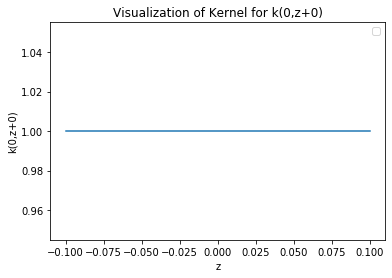

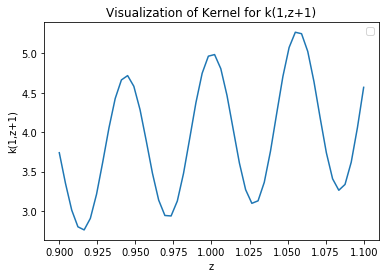

In [179]:
kernel_viz()

## Question 4: RBF

Construct a radial basis function (RBF) model that minimizes the least-squares loss
function. Use a Gaussian kernel and consider the grid of shape parameter values θ =
{0.05, 0.1, 0.5, 1, 2}, consider the grid of regularization parameters {0.001, 0.01, 0.1, 1},
and construct the model using Cholesky factorization. Select the hyperparameters
across the grid of possible values by evaluating on the validation set. Construct the
model on the datasets iris, rosenbrock (with n train=1000, d=2), and mauna loa.
Use both the training and validation sets to predict on the test set, and format your
results in a table (present test RMSE for regression datasets, and test accuracy for
classification datasets).

In [41]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
x_total = np.vstack([x_train, x_valid])
y_total = np.vstack([y_train, y_valid])

In [42]:
def gaussian_kernel(x,z,theta):
    return np.exp(-(np.linalg.norm([x-z],ord=2))**2/theta)

In [ ]:
# RBF Regression model is of the form: f(x,alpha) = sum(alpha_i*kernel(x,x_i))
def rbf(dataset,x_training,y_training,x_testing,y_testing, theta_vals, reg_params):
    if not theta_vals and not reg_params:
        theta_vals = [0.05, 0.1, 0.5, 1, 2]
        reg_params = [0.001, 0.01, 0.1, 1]
        test = False
    else:
        test = True
    results = list([])
    
    for theta in theta_vals:
#         K = np.empty((x_training.size, x_training.size))
        K = np.empty((len(x_training), len(x_training)))
        kernel = np.empty((len(x_testing), len(x_training)))
    
        for i in range(len(x_training)):
            for j in range(len(x_training)):
                K[i,j] = gaussian_kernel(x_training[i], x_training[j],theta)
                if i!=j:
                    K[j,i] = K[i,j]

        for i in range(len(x_testing)):
            for j in range(len(x_training)):
                kernel[i,j] = gaussian_kernel(x_testing[i],x_training[j],theta)
    
        for l_param in reg_params:
            
            # Compute alpha with Cholesky factorization with gram matrix K + lambda*identity as per lecture slides  
            R = np.linalg.cholesky(K+l_param*np.identity(len(K)))
            R_inv = np.linalg.inv(R)

            # Compute alpha
            alpha = np.dot(np.dot(R_inv.T, R_inv), y_training)
            
            # Predict using alpha and kernel array 
            if dataset == 'mauna_loa' or dataset == 'rosenbrock': # If regression dataset 
                predictions = np.dot(kernel, alpha)
                rmse_val = rmse(predictions,y_testing)
                results.append([rmse_val, theta, l_param])

            else: # If classification datasets
                predictions = np.argmax(np.dot(kernel, alpha), axis=1)
                y_testing_new = np.argmax(1*y_testing, axis=1)
                pred_acc = (predictions == y_testing_new).sum()/len(y_testing_new)
                results.append([pred_acc, theta, l_param])
    # Get optimal parameters 
    results = np.array(results)
    if test==False:
        if dataset == 'mauna_loa' or dataset == 'rosenbrock':
            return results[(np.argmin(results, axis=0))[0]]
        else:
            return results[(np.argmax(results, axis=0))[0]]
    else:
        return results[0][0]

In [44]:
best_rmse, opt_theta, opt_param = rbf('mauna_loa',x_train,y_train,x_valid,y_valid,[],[])
print('Validation RMSE for mauna_loa:' , best_rmse)
print('Optimal theta for mauna_loa:' , opt_theta)
print('Optimal Regularization Parameter for mauna_loa:' , opt_param)

Validation RMSE for mauna_loa: 0.12447867031587516
Optimal theta for mauna_loa: 1.0
Optimal Regularization Parameter for mauna_loa: 0.001


In [46]:
test_rmse = rbf('mauna_loa',x_total,y_total,x_test,y_test,[opt_theta],[opt_param])
print('Test RMSE for mauna_loa:', test_rmse)

Test RMSE for mauna_loa: 0.1497733877240507


In [13]:
## Testing Rosenbrock Dataset 

In [51]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)

In [52]:
best_rmse, opt_theta, opt_param = rbf('rosenbrock',x_train,y_train,x_valid,y_valid,[],[])
print('Validation RMSE for rosenbrock:' , best_rmse)
print('Optimal theta for rosenbrock:' , opt_theta)
print('Optimal Regularization Parameter for rosenbrock:' , opt_param)

Validation RMSE for rosenbrock: 0.19323958697369994
Optimal theta for rosenbrock: 2.0
Optimal Regularization Parameter for rosenbrock: 0.001


In [53]:
test_rmse = rbf('rosenbrock',x_total,y_total,x_test,y_test,[opt_theta],[opt_param])
print('Test RMSE for rosenbrock:', test_rmse)

Test RMSE for rosenbrock: 1.427520111246271


In [ ]:
## Testing Iris Dataset 

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')

In [ ]:
pred_acc, opt_theta, opt_param = rbf('iris',x_train,y_train,x_valid,y_valid,[],[])
print('Prediction Accuracy for iris:' , pred_acc)
print('Optimal theta for iris:' , opt_theta)
print('Optimal Regularization Parameter for iris:' , opt_param)

In [ ]:
test_acc = rbf('iris',x_total,y_total,x_test,y_test,[opt_theta],[opt_param])
print('Test Prediction Accuracy for mauna_loa:', test_acc)

## Question 5

In [57]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=200, d=2)
x_total = np.vstack([x_train, x_valid])
y_total = np.vstack([y_train, y_valid])

In [61]:
def greedy_regression(x_train,y_train,x_valid,y_valid,theta,k_range):
    basis_funct_dict = list(range(len(x_train)))
    
    selected = list([])
    candidates = (basis_funct_dict)
    
    N = len(x_train)
    k = 0
    J = list([])
    prev_mdl = np.inf 
    r = y_train # Initially, residual is everything 
#     while (np.linalg.norm(r,ord=2)) > mdl:
#         k += 1 
    for k in range(1,k_range+1):
        J = list([])
        
#         for index in candidates:
#             phi_col = np.zeros((len(x_train), ))
#             for item in range(len(x_train)):
#                 phi_col[item] = gaussian_kernel(x_train[item], x_train[index], theta)
#             val = (np.dot(phi_col.T, r))**2 / np.dot(phi_col.T, phi_col)
#             J.append((index, val))
        
        
        # Pick a new basis function from candidates based on J
        for idx in candidates:
            phi_col = np.empty((len(x_train), ))
            for i in range(len(x_train)):
                phi_col[i] = gaussian_kernel(x_train[i], x_train[idx], theta)
            J_val = (np.dot(phi_col.T, r))**2/np.dot(phi_col.T, phi_col)
#             print(J_val)
            J.append([idx, float(J_val)])

#         J = np.array(J)
#         print(J)
#         print(np.argmax(J, axis=0))
#         i_k = np.argmax(J, axis=0)[1]

        e = -1 
        i_k = -1 
        for i in range(len(J)):
            if (e < J[i][1]):
                i_k = J[i][0]
                e = J[i][1]
#         error_reduction = 0
#         best_index = -1
#         for i in J:
#             if (error_reduction < i[1]):
#                 best_index = i[0]
#                 error_reduction = i[1]
        
        # Add basis function index to selected and remove from candidates 
        selected.append(i_k)
        candidates.remove(i_k)
#         print(i_k,'i')
        # Construct Phi(k) 
#         phi = np.empty(x_train.size,1)
        phi = np.empty((len(x_train), 1))
        for i in range(len(x_train)):
            phi[i] = gaussian_kernel(x_train[selected[-1]],x_train[i],theta) # Use the most recently added basis function index 
        
        if k > 1:
            Phi = np.hstack([Phi, phi]) 
        else:
            Phi = phi
        
        # Use SVD to estimate weights 
        u, s, vh = np.linalg.svd(Phi)
    
        dummy = np.zeros( (len(x_train) - (len(s)), (len(s))) )
        sigma = np.vstack([np.diag(s), dummy])
        
        # In this case we disregard the + lambda factor 
        intermediate = np.linalg.inv(np.dot(sigma.T, sigma)) 
        w = np.dot(vh.T, np.dot(intermediate, np.dot(sigma.T, np.dot(u.T, y_train))))
        
        preds = np.dot(Phi, w)
        
        # Update residual 
        r = y_train - preds
        
        # Compute MDL loss
        mdl = (N/2)*math.log(np.linalg.norm(r, ord=2)) + k/2*math.log(N)

        # Check for stop condition 
        if mdl < prev_mdl:
            prev_mdl = mdl
            opt_k = k 
            opt_w = w
        elif mdl > prev_mdl:
#             print([opt_k, mdl, prev_mdl])
            break 
    
    # Computing Test RMSE results
    selected = selected[:-1]
    phi_t = np.empty((len(x_total), len(selected)))
    
    for i in range(len(x_total)):
        for sel_idx in range(len(selected)):
            phi_t[i][sel_idx] = gaussian_kernel(x_total[selected[sel_idx]],x_total[i],theta) # Use the most recently added basis function index 

    # Use SVD to estimate weights 
    u, s, vh = np.linalg.svd(phi_t)

    dummy = np.zeros( (len(x_total) - (len(s)), (len(s))) )
    sigma = np.vstack([np.diag(s), dummy])

    # In this case we disregard the + lambda factor 
    intermediate = np.linalg.inv(np.dot(sigma.T, sigma)) 
    w = np.dot(vh.T, np.dot(intermediate, np.dot(sigma.T, np.dot(u.T, y_total))))

    phi_test = np.empty((len(x_test), len(selected)))
    
    for i in range(len(x_test)):
        for sel_idx in range(len(selected)):
            phi_test[i][sel_idx] = gaussian_kernel(x_test[selected[sel_idx]],x_test[i],theta) # Use the most recently added basis function index 

    preds = np.dot(phi_test, opt_w) # 1.369

    rmse_test = rmse(preds, y_test)
    return [opt_k, rmse_test]

In [62]:
theta = [0.01,0.1,1]
k_range = 200
for theta_val in theta:
    print('For theta = '+str(theta_val))
    sparsity, rmse_test = greedy_regression(x_train,y_train,x_valid,y_valid,theta_val,k_range)
    print('Sparsity = ' + str(sparsity) +', with Test RMSE of '+ str(rmse_test))

For theta = 0.01
Sparsity = 12, with Test RMSE of 1.2453889005164207
For theta = 0.1
Sparsity = 40, with Test RMSE of 2.1328613873130813
For theta = 1
Sparsity = 11, with Test RMSE of 4.7421713851324645
